### 一、准备数据

`cifar2` 数据集为 `cifar10` 数据集的子集，只包括前两种类别 `airplane` 和 `automobile`。

训练集有 `airplane` 和 `automobile` 图片各 5000 张，测试集有 `airplane` 和 `automobile` 图片各1000张。

`cifar2` 任务的目标是训练一个模型来对飞机 `airplane` 和机动车 `automobile` 两种图片进行分类。

我们准备的 `Cifar2` 数据集的文件结构如下所示。

![Cifar2](data/cifar2.jpg)

在 `tensorflow` 中准备图片数据的常用方案有两种，第一种是使用 `tf.keras` 中的 `ImageDataGenerator` 工具构建图片数据生成器。

第二种是使用 `tf.data.Dataset` 搭配 `tf.image` 中的一些图片处理方法构建数据管道。

第一种方法更为简单，其使用范例可以参考以下文章。

[《Keras图像数据预处理范例——Cifar2图片分类》](https://mp.weixin.qq.com/s?__biz=MzU3OTQzNTU2OA==&mid=2247484795&idx=1&sn=16947726702b87ee535aef0d6ae2db30&chksm=fd676824ca10e1321e77c5fa44339c0a79442cd8d7fbcc58697be166a4b0f990306848724692&mpshare=1&scene=1&srcid=1227ARPw2Ir8nVC4B84CjcIx&sharer_sharetime=1609043128020&sharer_shareid=808295d573831eb57288f1fc0ad3ac69&key=a58ea5adca8c8f06e4a7b7a15ed218f88cbee52ab3ee0fca3f2dd3f0797a36a6de26f8e75bd4787ddf97195c3959d94fe5060be0d3f9f6cd1eba11c0ad1ee37709088084d70034bd03efd43dacc32acd45a231c8359dd84ad73c28b11a9dc50556486b6e1e1ab89ad11da9621e5cdd858fcb53d91037d5116d638d12fced85b3&ascene=0&uin=MTYzMDEzMjAxMg%3D%3D&devicetype=iMac+MacBookAir7%2C2+OSX+OSX+10.14.6+build(18G6032)&version=11020113&lang=zh_CN&exportkey=A8nc9Ve3hcMzsggW3DOY8mU%3D&pass_ticket=JOjUjT6HXslkPfqXrPY1oG3qVEXbIIc1IAKdh8xjlrGyB8OtZ8JjRan45%2Ff%2Bknjb&wx_header=0)

第二种方法是 `TensorFlow` 的原生方法，更加灵活，使用得当的话也可以获得更好的性能。

我们此处介绍第二种方法。

In [1]:
import tensorflow as tf
from keras import layers, models

BATCH_SIZE = 100
EPOCHS = 15

def load_image(img_path, size=(32, 32)):
    # 构建标签，1 表示汽车，0 表示飞机
    label = (
        tf.constant(1, tf.int8)
        if tf.strings.regex_full_match(img_path, ".*automobile.*")
        else tf.constant(0, tf.int8)
    )
    img = tf.io.read_file(img_path)  # 读取图片
    img = tf.image.decode_jpeg(img)  # 解码 jpeg 图像
    img = tf.image.resize(img, size) / 255.0  # 调整图片大小，并归一化
    return (img, label)

In [2]:
# 使用并行化预处理 num_parallel_calls 和预存数据 prefetch 来提升性能
ds_train = (
    tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg")
    .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)  #
    .shuffle(buffer_size=1000)  # 打乱数据，buffer_size 为缓冲区大小，越大则乱序效果越好，但性能会下降
    .batch(BATCH_SIZE)  # 批次大小
    .prefetch(tf.data.experimental.AUTOTUNE)
)

ds_test = (
    tf.data.Dataset.list_files("./data/cifar2/test/*/*.jpg")
    .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

2022-04-23 19:29:06.079185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 19:29:06.108491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 19:29:06.108650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-23 19:29:06.109396: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

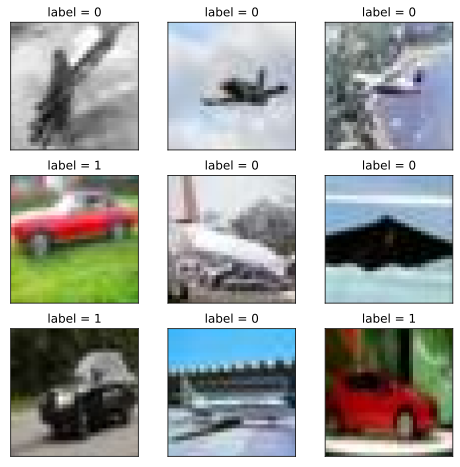

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

# 查看部分样本
plt.figure(figsize=(8, 8))
for i, (img, label) in enumerate(ds_train.unbatch().take(9)):
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d" % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [4]:
for x, y in ds_train.take(1):
    print("x.shape:", x.shape, "\ny.shape:", y.shape)

x.shape: (100, 32, 32, 3) 
y.shape: (100,)


### 二、定义模型

使用 `Keras` 接口有以下 3 种方式构建模型：
- 使用 `Sequential` 按层顺序构建模型
- 使用函数式 `API` 构建任意结构模型
- 继承 `Model` 基类构建自定义模型。

此处选择使用函数式 `API` 构建模型。

In [5]:
tf.keras.backend.clear_session()  # 清除会话

# 构建模型
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, kernel_size=(3, 3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, kernel_size=(5, 5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs=inputs, outputs=outputs)

# 输出模型概要信息
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0     

### 三，训练模型

训练模型通常有 3 种方法，内置 `fit` 方法，内置 `train_on_batch` 方法，以及自定义训练循环。此处我们选择最常用也最简单的内置 `fit` 方法。

In [6]:
import datetime
import os

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("./data/autograph", stamp)

if not os.path.isdir(logdir):
    os.makedirs(logdir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.binary_crossentropy,
    metrics=["accuracy"],
)

history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_test,
    callbacks=[tensorboard_callback],
    workers=4,
)

Epoch 1/15


2022-04-23 19:29:08.682499: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8303


100/100 [==============================] - 3s 8ms/step - loss: 0.4385 - accuracy: 0.7923 - val_loss: 0.3142 - val_accuracy: 0.8665
Epoch 2/15
100/100 [==============================] - 1s 8ms/step - loss: 0.3151 - accuracy: 0.8633 - val_loss: 0.2873 - val_accuracy: 0.8755
Epoch 3/15
100/100 [==============================] - 1s 7ms/step - loss: 0.2520 - accuracy: 0.8945 - val_loss: 0.2077 - val_accuracy: 0.9175
Epoch 4/15
100/100 [==============================] - 1s 7ms/step - loss: 0.2048 - accuracy: 0.9177 - val_loss: 0.1832 - val_accuracy: 0.9205
Epoch 5/15
100/100 [==============================] - 1s 7ms/step - loss: 0.1723 - accuracy: 0.9312 - val_loss: 0.1742 - val_accuracy: 0.9250
Epoch 6/15
100/100 [==============================] - 1s 7ms/step - loss: 0.1494 - accuracy: 0.9431 - val_loss: 0.1699 - val_accuracy: 0.9265
Epoch 7/15
100/100 [==============================] - 1s 7ms/step - loss: 0.1341 - accuracy: 0.9460 - val_loss: 0.1568 - val_accuracy: 0.9355
Epoch 8/15
100/10

### 四、评估模型

In [7]:
# %load_ext tensorboard
%reload_ext tensorboard
# %tensorboard --logdir ./data/autograph

from tensorboard import notebook
notebook.list()

# 在 tensorboard 中查看模型
notebook.start("--logdir ./data/autograph")

No known TensorBoard instances running.


In [8]:
# !kill $(lsof -t -i:6006) # 终止 tensorboard 进程

In [9]:
import pandas as pd

df_history = pd.DataFrame(history.history)
df_history.index = range(1, len(df_history) + 1)
df_history.index.name = "epoch"

df_history

,loss,accuracy,val_loss,val_accuracy
epoch,,,,
1,0.438497,0.7923,0.314177,0.8665
2,0.315068,0.8633,0.287315,0.8755
3,0.252006,0.8945,0.207724,0.9175
4,0.204771,0.9177,0.183154,0.9205
5,0.172332,0.9312,0.174246,0.9250
6,0.149413,0.9431,0.169901,0.9265
7,0.134060,0.9460,0.156774,0.9355
8,0.111524,0.9582,0.176931,0.9265
9,0.101229,0.9633,0.157380,0.9380


In [10]:
import matplotlib.pyplot as plt


def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history["val_" + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, "bo--")
    plt.plot(epochs, val_metrics, "ro-")
    plt.title("Training and validation " + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, "val_" + metric])
    plt.show()

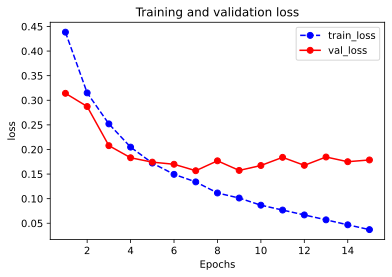

In [11]:
plot_metric(history, "loss")

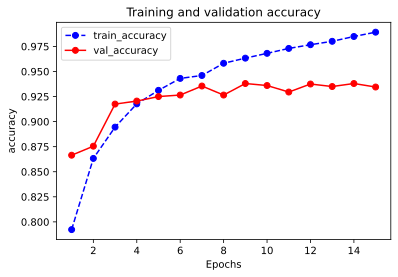

In [12]:
plot_metric(history, "accuracy")

### 五，使用模型

可以使用 `model.predict(ds_test)` 进行预测。

也可以使用 `model.predict_on_batch(x_test)` 对一个批量进行预测。

In [13]:
model.predict(ds_test)

array([[9.9999332e-01],
       [2.0291400e-05],
       [1.9959155e-02],
       ...,
       [9.9971598e-01],
       [3.5865000e-07],
       [1.4237502e-03]], dtype=float32)

In [14]:
for x, y in ds_test.take(1):
    print(model.predict_on_batch(x[0:20]))

[[2.5745249e-08]
 [9.9999952e-01]
 [7.0944488e-01]
 [9.9999976e-01]
 [9.8998696e-01]
 [9.9983525e-01]
 [9.9999952e-01]
 [9.5807910e-01]
 [2.4156946e-06]
 [1.0000000e+00]
 [9.9999106e-01]
 [3.2422664e-03]
 [9.9998045e-01]
 [7.6020032e-04]
 [7.9283339e-01]
 [9.9975699e-01]
 [9.8291665e-01]
 [9.9523503e-01]
 [9.6781015e-01]
 [9.9999499e-01]]


### 六、保存模型

推荐使用 `TensorFlow` 原生方式保存模型。

In [15]:
# 保存权重，该方式仅仅保存权重张量
model.save_weights("./data/tf_model_weights.ckpt", save_format="tf")

In [16]:
# 保存模型结构与模型参数，该方式保存的模型具有跨平台性，便于部署
model.save("./data/tf_model_saved_model", save_format="tf")
print("export saved model.")

model_loaded = models.load_model("./data/tf_model_saved_model")
model_loaded.summary()
model_loaded.evaluate(ds_test)

2022-04-23 19:29:25.858060: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./data/tf_model_saved_model/assets
export saved model.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                     

[0.17866569757461548, 0.934499979019165]